[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1U9TYyaSjs1hsp3p-C7Y2zNUhHHHzgd4p)

In [131]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
from attack import target_adversarial , fgsm_attack, test_fgsm_mnist , validation 
from Net import Net

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**GOAL :**
* Vanilla Deep NN 
* Code the attack : Fast gradient signed attackFGSM
* **Objective** : add the least amount of perturbation to the input data to cause the desired misclassification

Two assumptions : 
* white box: full access to model, architecture, inputs, outputs, and weights
* black box :  attacker only has access to the inputs and outputs of the model

We will focus on attacks following the white box assumption

# Data and Model

In [ ]:
mnist_testset = datasets.MNIST('./data_mnist', 
                   train=False,
                   download=True, 
                   transform=transforms.Compose([transforms.ToTensor()]))

In [114]:
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=1,shuffle=True)

In [111]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=False 

In [116]:
# Init device 
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Init the network
model = Net().to(device)

# Load pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()


CUDA Available:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

# FGSM attack 

$ pimage= x +  \epsilon * sign(\nabla_{x} J(\theta,x,y))$

where $\epsilon$ : how much we perturbe image $x$
 


In [139]:
def test_fgsm_mnist(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []
    # Loop over  test set
    loop = tqdm(test_loader,desc='Iteration for epsilon = {}'.format(epsilon))
    
    for i, (data, target) in enumerate(loop):
        if i == 1000 :
            break
        # Utile ila kan 3anna GPU
        data, target = data.to(device), target.to(device)
        # requires_grad attribute of Data tensor.
        #  !/! Important for Attack
        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] #index of the max log-probability

        if init_pred.item() != target.item():
            ## Skip this exemple
            continue

        # Calculate negative log likelihood loss used
        loss = F.nll_loss(output, target) 
        model.zero_grad()
        
        # Backward pass
        loss.backward()

        ## FGSM Attack
        # Collect datagrad
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Predict perturbed image class
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        if final_pred.item() == target.item(): # Nothing changed ( model has good defense)
            correct += 1
        else:
            #  Save au Max 5 adv exemples
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    final_acc = correct / float(len(test_loader))
    return final_acc, adv_examples


In [142]:
#%timeit 
accuracies = []
examples = []
epsilons =[0.1,0.3,0.5,0.7]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_fgsm_mnist(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Iteration for epsilon = 0.7:  10%|█         | 1000/10000 [00:27<04:06, 36.52it/s]


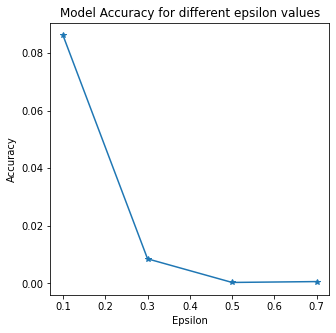

In [143]:
import seaborn as sns 
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(epsilons, accuracies, "*-")
#ax.yticks(np.arange(0, 1.1, step=0.1))
#ax.xticks(np.arange(0, .35, step=0.05))
plt.title("Model Accuracy for different epsilon values")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

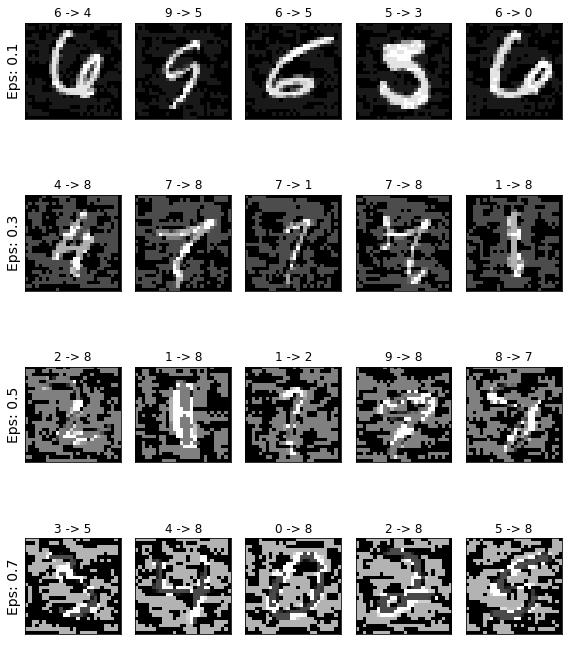

In [32]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()


**Problem :** 
* Adv exemples too different from the original output
* Can't target a specific output
* Test on differents architectures  

# L-BFGS attack
- Implement non targeted attack w pytorch 
    * set goal : $y_{goal}$ : one hot vector with $j^th$ positing as 1
    * Define cost : $C = 1/2*\|y_{goal} - y(x)\|^2$
- Implement targeted attack w pytorch

## Random attack

In [177]:
def adversarial(model, device, n=2,epochs = 10,eta=0.5):
    """
    net : network object
        neural network instance to use
    n :  goal label (just an int, the function transforms it into a one-hot vector)
    
    epochs : integer
        number of steps for gradient descent
    """
    # Set the goal output
    goal = torch.tensor([n]).to(device)
    
    #
    x = torch.randn(1,1,28,28).to(device)
    x.requires_grad = True
    
    # Gradient descent on the input
    for epoch in range(epochs):
        output = model(x)
        loss = F.nll_loss(output, goal) 
        model.zero_grad()
        # Backward pass
        loss.backward()
        # Get grad
        d = x.grad.data
        # The sGD update on x
        with torch.no_grad():
            # we don't need to update model params
            x -= eta * d     
            x.grad = None
    return x

 This image is classfied as a :  8


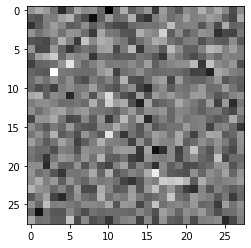

In [161]:
adv = adversarial(model,device,n=8)
label = model(adv).max(1, keepdim=True)[1]
adv = adv.squeeze().detach().cpu().numpy()
plt.imshow(adv,cmap='gray')
print(" This image is classfied as a : ", label.item())

--- 

## Targeted adversary

**Target adversarial :** Generate adversarial while trying to be close to an actual image

 $C = nullloss(y_{goal} - y(x)) +\lambda \|\vec x - \vec x_{target}\|^2_2 $

In [62]:
def target_adversarial(model,x_target, device, n=2,epochs = 200,eta=0.5, lmd=0.05):
    """
    net : network object
        neural network instance to use
    n :  goal label (just an int, the function transforms it into a one-hot vector)
    
    epochs : integer
        number of steps for gradient descent
    """
    # Set the goal output
    goal = torch.tensor([n]).to(device)
    
    #
    x = torch.randn(1,1,28,28).to(device)
    x.requires_grad = True
    
    # Gradient descent on the input
    for epoch in range(epochs):
        output = model(x)
        loss = F.nll_loss(output, goal) 
        model.zero_grad()
        # Backward pass
        loss.backward()
        # Get grad
        d = x.grad.data
        # The sGD update on x
        with torch.no_grad():
            # we don't need to update model params
            x -= eta * (d + lmd * (x - x_target)) 
            x.grad = None
    return x

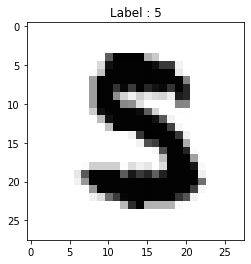

In [167]:
for d , t in test_loader : 
    data = d 
    target = t
    break
    
data_numpy = data.squeeze().detach().cpu().numpy()

fig, ax = plt.subplots()

ax.imshow(data_numpy,cmap='Greys')
ax.set_title("Label : {}".format(target.item()))
plt.show()

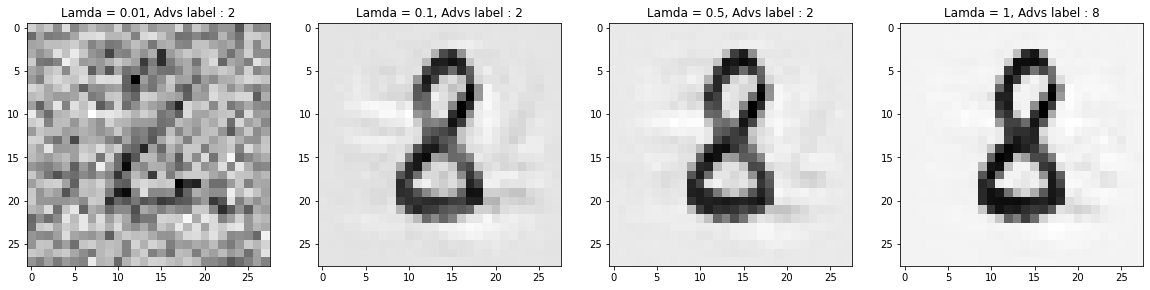

In [63]:
lmds =[0.01,0.1, 0.5,1]
fig, ax = plt.subplots(1,len(lmds),figsize=(20,10))

for i, lmd in enumerate(lmds) : 
    adv = target_adversarial(model,data,device,lmd=lmd)
    label = model(adv).max(1, keepdim=True)[1]
    adv = adv.squeeze().detach().cpu().numpy()
    ax[i].imshow(adv,cmap='Greys')
    ax[i].set_title("Lamda = {}, Advs label : {}".format(lmd,label.item()))
    

## Testing 

In [266]:
def test_LBFGS_mnist(model,device,testloader,lmd=lmd):
    correct = 0
    adv_examples = []
    loop = tqdm(testloader,desc='Lambda = {}'.format(lmd))
    for i, (data, target) in enumerate(loop):
        if i == 1000 :
            break
        data = data.to(device)
        target = target.to(target)
        data.requires_grad = True
        
        # Get initial label
        output = model(data)          
        init_pred = output.max(1, keepdim=True)[1] #index of the max log-probability
        if init_pred.item() != target.item():
            # Skip bad exemples in testdata
            continue  
        n=torch.tensor(0)
        while n.item() == target.item():
            n = torch.randint(low=0,high=9,size=(1,))
        # Generate Adversarial exemple
        adv = target_adversarial(model,data,device,n,lmd=lmd)       
        output = model(adv)
        final_pred = output.max(1, keepdim=True)[1]
        # If same label changed
        if final_pred.item() == target.item(): 
             correct += 1
        else :
            if len(adv_examples) < 5:
                adversary = adv.squeeze().detach().cpu().numpy()
                original = data.squeeze().detach().cpu().numpy()
                adv_examples.append((original, adversary, init_pred , final_pred))
    final_acc = correct / float(len(testloader))
    return final_acc, adv_examples

In [267]:
%reload_ext autoreload

In [257]:
accuracies = []
examples = []
lmds =[0.01,0.1, 0.5,1]

# Run test for each epsilon
for lmd in lmds:
    acc, ex = test_LBFGS_mnist(model, device, test_loader, lmd)
    accuracies.append(acc)
    examples.append(ex)

Lambda = 1:   0%|          | 10/10000 [00:14<4:07:20,  1.49s/it]


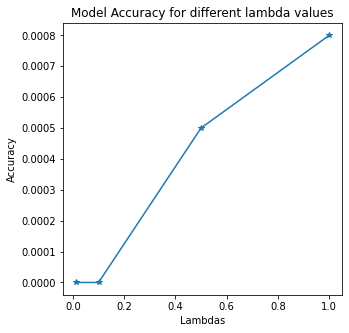

In [258]:
import seaborn as sns 
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(lmds, accuracies, "*-")
plt.title("Model Accuracy for different lambda values")
plt.xlabel("Lambdas")
plt.ylabel("Accuracy")
plt.show()

IndexError: list index out of range

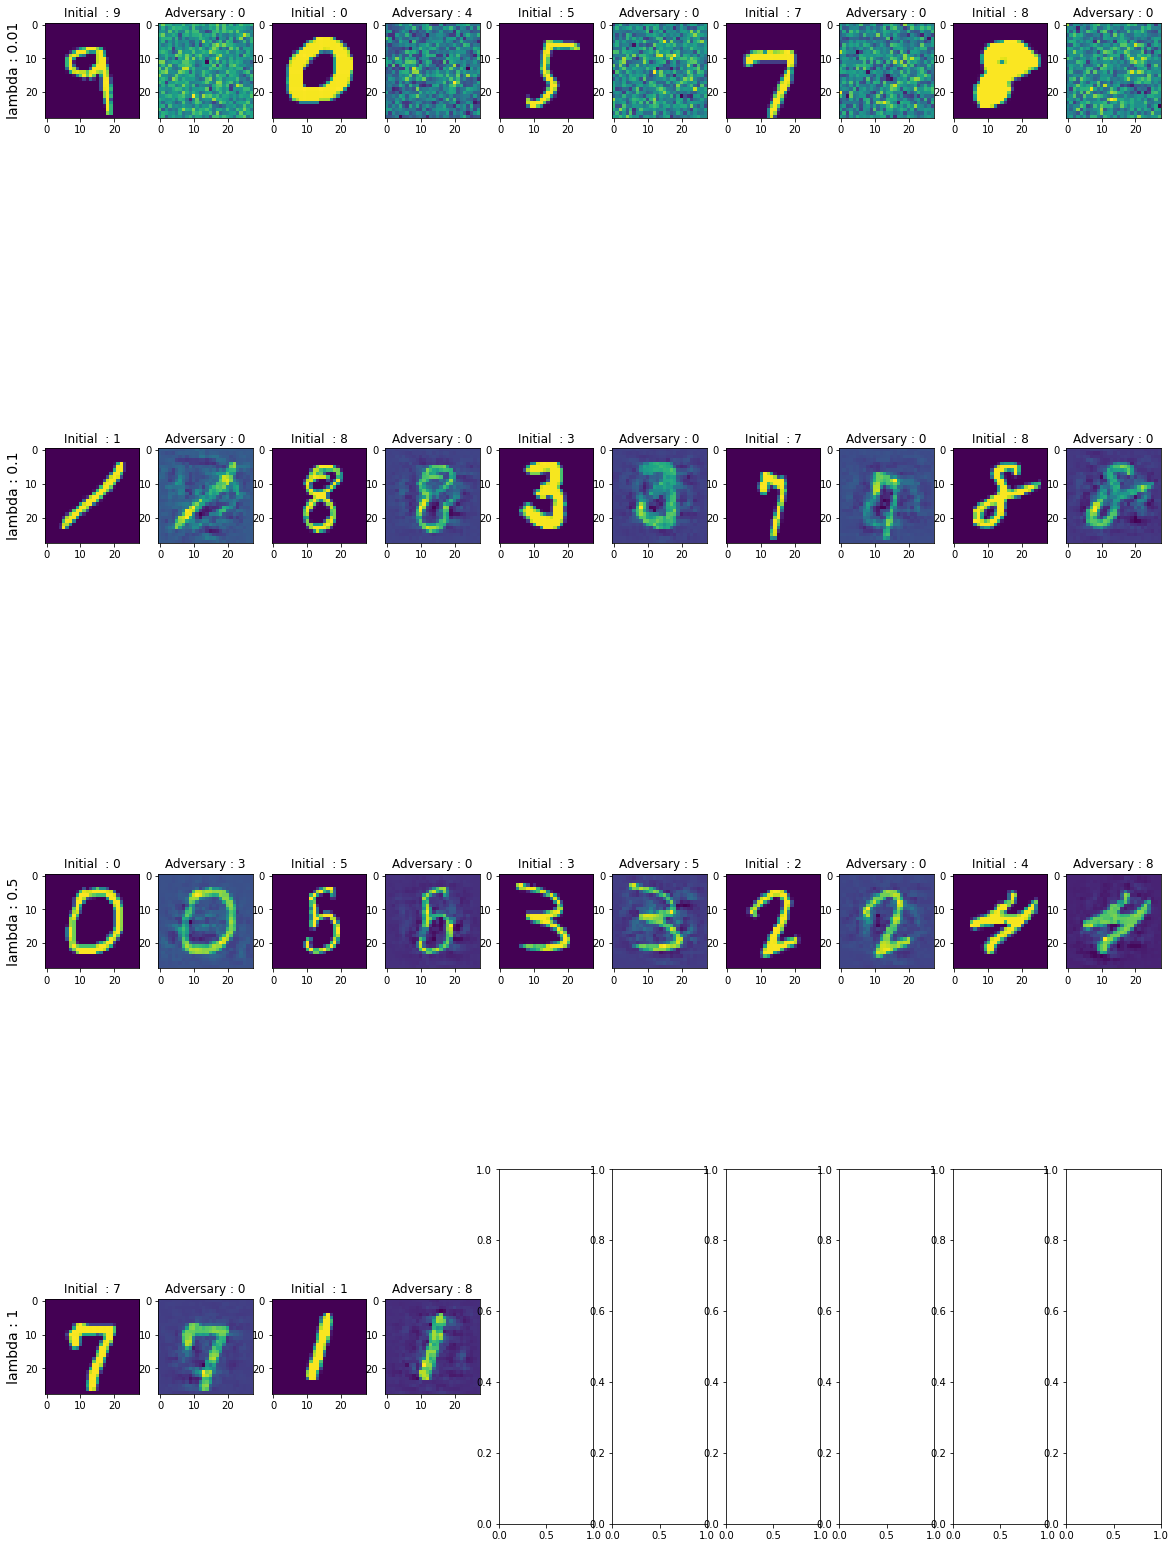

In [260]:
fig , axs = plt.subplots(nrows=len(lmds), ncols=len(examples[0])*2,figsize=(20,30))

for i , lmd in enumerate(lmds):
    for j in range(0,len(examples[0])):
        original, adversary, init_pred , final_pred = examples[i][j]
        axs[i, 2*j].imshow(original)
        axs[i,0].set_ylabel("lambda : {}".format(lmd), fontsize=14)
        axs[i, 2*j].set_title('Initial  : {}'.format(init_pred.item()))
        axs[i, 2*j+1].imshow(adversary)
        axs[i, 2*j+1].set_title('Adversary : {}'.format(final_pred.item()))

**TO DO** : 
* Check for multiple values
* Defenses : 
     * Binary thresholding
     * Reduce quality before
     * Generate exemples and train them ( Brute force approach
* Use other dataset (maybe use GPU)

# Defense

## Binary threshold

The main idea is to get rid of the noise in the image before infering the class. This would take care of the adversarial exemple.

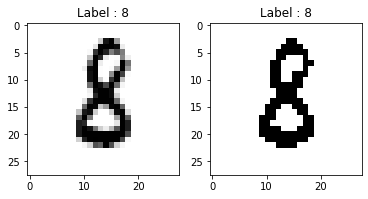

In [67]:
threshold = 0.5
data_binary = (data>threshold)*1

data_numpy_binary = data_binary.squeeze().detach().cpu().numpy()
data_numpy = data.squeeze().detach().cpu().numpy()

fig, ax = plt.subplots(1,2)

ax[0].imshow(data_numpy,cmap='Greys')
ax[1].imshow(data_numpy_binary,cmap='Greys')
ax[0].set_title("Label : {}".format(target.item()))
ax[1].set_title("Label : {}".format(target.item()))

plt.show()

In [69]:
## Testing with L-GSM

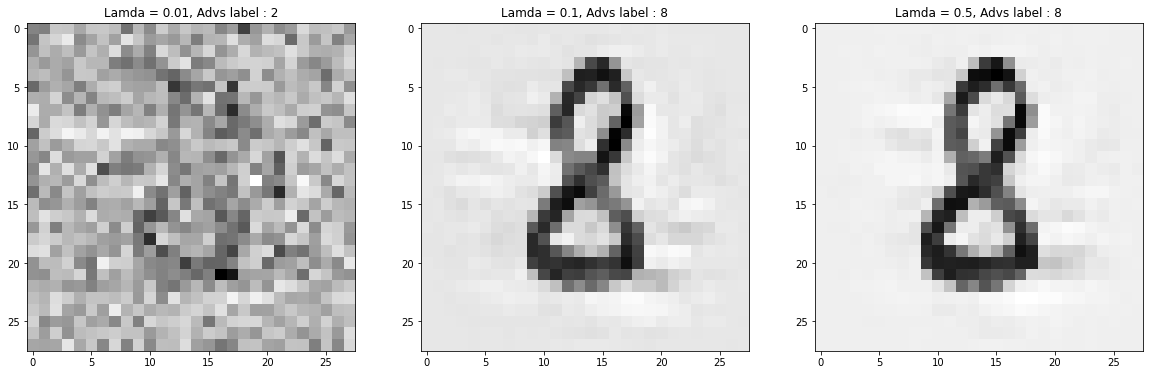

In [74]:
lmds =[0.01,0.1, 0.5]
fig, ax = plt.subplots(1,len(lmds),figsize=(20,10))

for i, lmd in enumerate(lmds) : 
    adv = target_adversarial(model,data,device,lmd=lmd)
    # Binary threashold
    adv_binary = (adv>threshold)*1
    label = model(adv_binary.to(torch.float32)).max(1, keepdim=True)[1]
    adv = adv.squeeze().detach().cpu().numpy()
    ax[i].imshow(adv,cmap='Greys')
    ax[i].set_title("Lamda = {}, Advs label : {}".format(lmd,label.item()))
    

Testing accuracy using L-GSM 

In [61]:
output = model(data_binary.to(torch.float32))
init_pred = output.max(1, keepdim=True)[1] #index of the max log-probability

In [ ]:
final_acc, adv_examples =  generate_adv_mnist(model, device, [data], epsilon=0.1):